<a href="https://colab.research.google.com/github/VishalSingh1703/ML-Practice/blob/main/Dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

<ipython-input-1-14b016e2b57d>:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Dropout Regularization


In [2]:
prob = 0.5

dropout = nn.Dropout(p = prob) # default is 0.5 only!
x = torch.ones(10)

# dropout.eval() # As soon as we turn eval mode on the dropout is turned off

y = dropout(x)
print(y)
print(y*(1-prob)) # scaled down
print(torch.mean(y))


# another way of turning dropout on or off is:
z = F.dropout(x, training = True)
print(z)
print(torch.mean(z))

tensor([0., 0., 2., 2., 2., 2., 0., 0., 0., 0.])
tensor([0., 0., 1., 1., 1., 1., 0., 0., 0., 0.])
tensor(0.8000)
tensor([0., 2., 2., 0., 2., 0., 0., 0., 0., 2.])
tensor(0.8000)


# Dropout Reg in practice

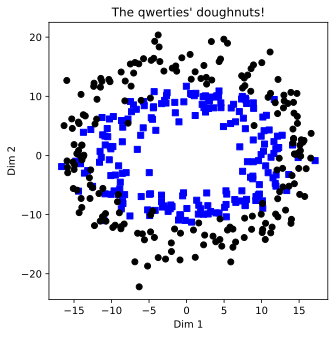

In [3]:
nPerClust = 200
th = np.linspace(0, 4*np.pi, nPerClust)
r1 = 10
r2 = 15

# generate the data
a = [ r1*np.cos(th) + np.random.randn(nPerClust)*3 ,
      r1*np.sin(th) + np.random.randn(nPerClust) ]
b = [ r2*np.cos(th) + np.random.randn(nPerClust) ,
      r2*np.sin(th) + np.random.randn(nPerClust)*3]

# true labels
labels_np = np.vstack((np.zeros((nPerClust, 1)), np.ones((nPerClust, 1))))

# concatenation inot a matrix
data_np = np.hstack((a, b)).T

# convert to a pytorch Tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# show the data
fig = plt.figure(figsize = (5, 5))
plt.plot(data[np.where(labels == 0)[0],0], data[np.where(labels == 0)[0], 1], 'bs')
plt.plot(data[np.where(labels == 1)[0],0], data[np.where(labels == 1)[0], 1], 'ko')
plt.title("The qwerties' doughnuts!")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.show()

# Seperate the data into DataLoaders

In [5]:
# use scikitlearn to split the data
train_data, test_data, train_labels, test_labels =  \
                train_test_split(data, labels, test_size = 0.2)

# convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# finally, translate into dataloader objects
batchsize = 16
train_loader = DataLoader(train_data, batch_size = batchsize, shuffle = True)
test_loader = DataLoader(test_data, batch_size = test_data.tensors[0].shape[0])

In [6]:
class theModelClass(nn.Module):
  def __init__(self, dropoutRate):
    super().__init__()

    ## layers
    self.input = nn.Linear(2, 128)
    self.hidden = nn.Linear(128, 128)
    self.output = nn.Linear(128, 1)

    # parameters
    self.dr = dropoutRate

  # forward pass
  def forward(self, x):
    # pass the data through the input layer
    x = F.relu( self.input(x) )

    # dropout after input layer
    x = F.dropout(x, p = self.dr, training = self.training)

    # pass the data through the hidden layer
    x = F.relu( self.hidden(x) )

    # dropout after hidden layer
    x = F.dropout(x, p = self.dr, training = self.training)

    # output layer
    x = self.output(x)

    # no dropout here!! there's only one node in output layer. no need to dropout
    return x

In [10]:
# test the model
tmpnet = theModelClass(0.25)

# run some random data through
tmpdata = torch.randn((10, 2))
yhat = tmpnet(tmpdata)
yhat

# this output does not matter. We run this cell just to check for error
# messages. No need to care about the data

tensor([[-0.1690],
        [-0.3961],
        [-0.1587],
        [-0.1840],
        [-0.0703],
        [-0.1276],
        [-0.1204],
        [-0.2895],
        [-0.2449],
        [-0.2292]], grad_fn=<AddmmBackward0>)

# Functions to create and train the net

In [11]:
def createANewModel(dropoutrate):

  # grab an instacne of the model class
  ANNQC = theModelClass(dropoutrate)

  # loss function
  lossfun = nn.BCEWithLogitsLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNQC.parameters(), lr = 0.002)

  return ANNQC, lossfun, optimizer

In [18]:
# train the model
# training parameter
epochs = 1000
# NOTE: this time the model, lossfun, and optimizer are inputs inot the function!
def trainTheModel(ANNQC, lossfun, optimizer):

  #initialize accuracies as empties (not storing losses here)
  trainAcc = []
  testAcc = []

  # switch training mode on (is this the right place for this code??)

  #loop over epochs
  for epochi in range(epochs):
    ANNQC.train()

    # loop over training data batches
    batchAcc = []
    for X, y in train_loader:

      # forward pass and loss
      yHat = ANNQC(X)
      loss = lossfun(yHat, y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch
      batchAcc.append( 100*torch.mean(((yHat > 0.5) == y).float()).item() )
    # end of batch loop

    # now that we've trained throught he batches, get their avg training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # test accuracy
    ANNQC.eval()
    X, y = next(iter(test_loader)) # extract X, y from test dataloader
    yHat = ANNQC(X)
    testAcc.append( 100*torch.mean(((yHat > 0.5) == y).float()).item() )

  # output
  return trainAcc, testAcc

# Test the model

In [21]:
# create a model
dropoutrate = 0
ANNQC, lossfun, optimzer = createANewModel(dropoutrate)

# train the model
trainAcc, testAcc = trainTheModel(ANNQC, lossfun, optimzer)

In [22]:
# create a 1D smoothing filter
def smooth(x, k = 5):
  return np.convolve(x, np.ones(k)/k, mode = 'same')

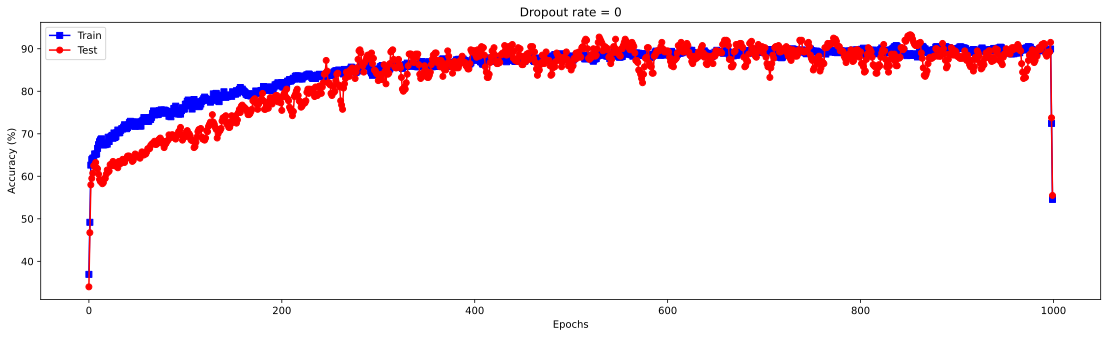

In [24]:
# plot the results

fig = plt.figure(figsize = (19, 5))
plt.plot(smooth(trainAcc), 'bs-')
plt.plot(smooth(testAcc), 'ro-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train', 'Test'])
plt.title('Dropout rate = %g'%dropoutrate)

plt.show()